<a href="https://colab.research.google.com/github/Lgvalia/MIT-Soviet-Symbol-Detection/blob/main/MIT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
train_folder = '/content/drive/MyDrive/MIT_Project/data/New Soviet Symbol Data/train'
test_folder =  '/content/drive/MyDrive/MIT_Project/data/New Soviet Symbol Data/test'

In [ ]:
# Edited by Ahmed

from PIL import Image
import os
import numpy as np
from torchvision import transforms

images = []
labels = []
i=0
img_tranform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((1024, 1024)) #ეს შეგვიძლია შევცვალოთ, ნიმუშად 256, 256 ჩაგვიწერა
])

#train data list
for filename in sorted(os.listdir(train_folder)):
  if filename[-3:]=='txt':
    with open(os.path.join(train_folder, filename)) as f:
      labels.append(f.read())
  else:
    img = Image.open(os.path.join(train_folder, filename))
    img_tensor = img_tranform(img)
    images.append(img_tensor)
    # print(img.size)
    i+=1
    # print(i)

img_lab_train = []
for i in range(len(images)):
  lst = []
  lst.append(images[i])
  lst.append((int(labels[i].split(" ")[0]), [float(e) for e in labels[i].split(" ")[1:]]))
  img_lab_train.append(lst)


#test data list
for filename in sorted(os.listdir(test_folder)):
  if filename[-3:]=='txt':
    with open(os.path.join(test_folder, filename)) as f:
      labels.append(f.read())
  else:
    img = Image.open(os.path.join(test_folder, filename))
    img_tensor = img_tranform(img)
    images.append(img_tensor)
    # print(img.size)
    i+=1
    # print(i)

img_lab_test = []
for i in range(len(images)):
  lst = []
  lst.append(images[i])
  lst.append((int(labels[i].split(" ")[0]), [float(e) for e in labels[i].split(" ")[1:]]))
  img_lab_test.append(lst)

In [ ]:
import torch

class MyIterableDataset(torch.utils.data.IterableDataset):
  def __init__(self, dataset):
    super(MyIterableDataset).__init__()
    self.dataset = dataset

  def __iter__(self):
    return iter(self.dataset)

  def __getitem__(self, k):
    for i, v in enumerate(self):
      if i == k: return v

In [ ]:
""" Displays an image """
def display(image):
    print(f"Image Size: {image.shape}")
    plt.imshow(image, cmap="gray")
    plt.show()

Image Size: torch.Size([1024, 1024, 3])


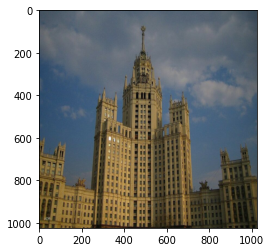

Image Size: torch.Size([1024, 1024, 3])


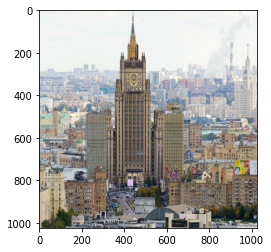

Image Size: torch.Size([1024, 1024, 3])


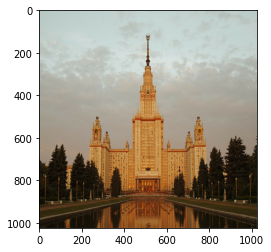

In [ ]:
batch_size = 64

train_dataset = MyIterableDataset(img_lab_train)
train_loader = DataLoader(train_dataset, batch_size=1)

test_dataset = MyIterableDataset(img_lab_test)
test_loader = DataLoader(test_dataset, batch_size=1)

for i in range(3):
  image, label = test_dataset[i]
  display(image.permute(1, 2, 0))

In [ ]:
from torchvision.models import resnet50

In [ ]:
resnet = resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
newmodel = torch.nn.Sequential(
    *(list(resnet.children())[:-2]),
    nn.Flatten(),
    nn.Linear(
        in_features=2048 * 32 * 32,
        out_features=1
    ),
    nn.Sigmoid()
  ).to(device)
print(newmodel)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
num_epochs = 300

train_losses = []
def train(model, dataloader):
  print("TRAINING")
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  loss_function = nn.CrossEntropyLoss()
  model.train()

  for epoch in tqdm(range(num_epochs)):
    running_loss = 0
    for idx, (images, labels) in enumerate(train_loader):

      # print(images.shape)
      images = images.to(device)

      prediction = model(images)
      # print(prediction.shape)
      loss = loss_function(prediction,torch.Tensor([[1.0]]).to(device))
      running_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_losses.append(running_loss / batch_size)
    if epoch % 10 == 0:
      print(f"\nEpoch {epoch}/{num_epochs}, Loss: {running_loss / batch_size}")

def test(model, dataloader):
  print('TESTING')
  model.eval()
  with torch.no_grad():
    for idx, (images, labels) in enumerate(dataloader):
      # images = images.squeeze(1)
      images = images.to(device)
      prediction = model(images)

      print("original images")
      display(images[0].cpu().permute(1, 2, 0))
      print(prediction)
      if idx > 3: break
    print("TESTING FINISHED")

In [ ]:
# print(type(newmodel))
# print(type(train_loader))
train(newmodel, train_loader)

TRAINING


  0%|          | 1/300 [00:22<1:51:58, 22.47s/it]


Epoch 0/300, Loss: 0.0


  4%|▎         | 11/300 [03:05<1:18:51, 16.37s/it]


Epoch 10/300, Loss: 0.0


  7%|▋         | 21/300 [05:48<1:15:47, 16.30s/it]


Epoch 20/300, Loss: 0.0


 10%|█         | 31/300 [08:31<1:13:02, 16.29s/it]


Epoch 30/300, Loss: 0.0


 14%|█▎        | 41/300 [11:14<1:10:21, 16.30s/it]


Epoch 40/300, Loss: 0.0


 17%|█▋        | 51/300 [13:57<1:07:39, 16.30s/it]


Epoch 50/300, Loss: 0.0


 20%|██        | 61/300 [16:40<1:04:56, 16.30s/it]


Epoch 60/300, Loss: 0.0


 24%|██▎       | 71/300 [19:23<1:02:10, 16.29s/it]


Epoch 70/300, Loss: 0.0


 27%|██▋       | 81/300 [22:06<59:31, 16.31s/it]


Epoch 80/300, Loss: 0.0


 30%|███       | 91/300 [24:50<56:49, 16.31s/it]


Epoch 90/300, Loss: 0.0


 34%|███▎      | 101/300 [27:32<54:01, 16.29s/it]


Epoch 100/300, Loss: 0.0


 37%|███▋      | 111/300 [30:15<51:21, 16.31s/it]


Epoch 110/300, Loss: 0.0


 40%|████      | 121/300 [32:59<48:41, 16.32s/it]


Epoch 120/300, Loss: 0.0


 44%|████▎     | 131/300 [35:42<45:56, 16.31s/it]


Epoch 130/300, Loss: 0.0


 47%|████▋     | 141/300 [38:25<43:13, 16.31s/it]


Epoch 140/300, Loss: 0.0


 50%|█████     | 151/300 [41:08<40:29, 16.31s/it]


Epoch 150/300, Loss: 0.0


 54%|█████▎    | 161/300 [43:51<37:45, 16.30s/it]


Epoch 160/300, Loss: 0.0


 57%|█████▋    | 171/300 [46:34<35:03, 16.31s/it]


Epoch 170/300, Loss: 0.0


 60%|██████    | 181/300 [49:17<32:19, 16.29s/it]


Epoch 180/300, Loss: 0.0


 64%|██████▎   | 191/300 [52:00<29:35, 16.29s/it]


Epoch 190/300, Loss: 0.0


 67%|██████▋   | 201/300 [54:43<26:53, 16.30s/it]


Epoch 200/300, Loss: 0.0


 70%|███████   | 211/300 [57:26<24:09, 16.28s/it]


Epoch 210/300, Loss: 0.0


 74%|███████▎  | 221/300 [1:00:09<21:28, 16.31s/it]


Epoch 220/300, Loss: 0.0


 77%|███████▋  | 231/300 [1:02:52<18:44, 16.29s/it]


Epoch 230/300, Loss: 0.0


 80%|████████  | 241/300 [1:05:35<16:01, 16.30s/it]


Epoch 240/300, Loss: 0.0


 84%|████████▎ | 251/300 [1:08:18<13:18, 16.30s/it]


Epoch 250/300, Loss: 0.0


 87%|████████▋ | 261/300 [1:11:01<10:35, 16.29s/it]


Epoch 260/300, Loss: 0.0


 90%|█████████ | 271/300 [1:13:44<07:52, 16.28s/it]


Epoch 270/300, Loss: 0.0


 94%|█████████▎| 281/300 [1:16:27<05:09, 16.30s/it]


Epoch 280/300, Loss: 0.0


 97%|█████████▋| 291/300 [1:19:10<02:26, 16.33s/it]


Epoch 290/300, Loss: 0.0


100%|██████████| 300/300 [1:21:37<00:00, 16.32s/it]


TESTING
original images
Image Size: torch.Size([1024, 1024, 3])


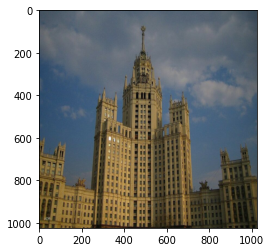

tensor([[0.5647]], device='cuda:0')
original images
Image Size: torch.Size([1024, 1024, 3])


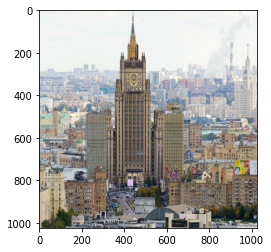

tensor([[0.6238]], device='cuda:0')
original images
Image Size: torch.Size([1024, 1024, 3])


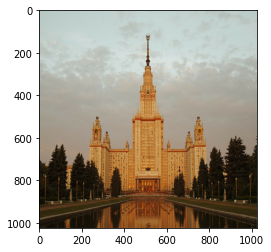

tensor([[0.4386]], device='cuda:0')
original images
Image Size: torch.Size([1024, 1024, 3])


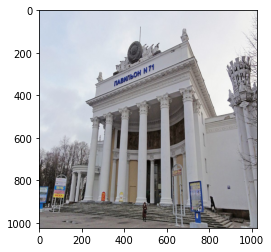

tensor([[0.6644]], device='cuda:0')
original images
Image Size: torch.Size([1024, 1024, 3])


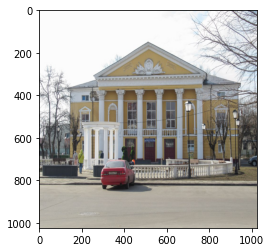

tensor([[0.5644]], device='cuda:0')
TESTING FINISHED


In [ ]:
test(newmodel, test_loader)

original images
Image Size: torch.Size([1024, 1024, 3])


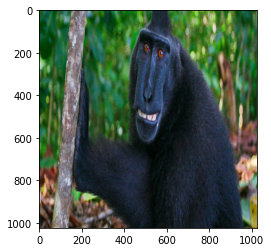

tensor([[0.3690]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
images = img_tranform(Image.open("/content/Monkey.jpg")).unsqueeze(0)
images = images.to(device)
prediction = newmodel(images)

print("original images")
display(images[0].cpu().permute(1, 2, 0))
print(prediction)